In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

%load_ext pycodestyle_magic

In [2]:
data = pd.read_csv('data/DRV_seattleBuilding_full.csv')

In [3]:
data.head()

,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,median_SourceEUI(kBtu/sf),median_SiteEUI(kBtu/sf),p_NaturalGas,p_Electricity,p_SteamUse
0,2015,NonResidential,Hotel/Senior Care/Housing,98101.0,7,DOWNTOWN,47.612190,-122.337997,1927,1.0,...,No information,0.0,65.0,6981428.0,249.43,162.0,76.0,0.18,0.53,0.29
1,2015,NonResidential,Hotel/Senior Care/Housing,98101.0,7,DOWNTOWN,47.613106,-122.333358,1996,1.0,...,Leisure,4622.0,51.0,8354235.0,263.51,162.0,76.0,0.53,0.47,0.00
2,2015,NonResidential,Hotel/Senior Care/Housing,98101.0,7,DOWNTOWN,47.613349,-122.337699,1969,1.0,...,Swimming Pool,0.0,18.0,73130656.0,2061.48,162.0,76.0,0.05,0.68,0.27
3,2015,NonResidential,Hotel/Senior Care/Housing,98101.0,7,DOWNTOWN,47.614216,-122.336609,1926,1.0,...,No information,0.0,1.0,28229320.0,1936.34,162.0,76.0,0.07,0.10,0.83
4,2015,NonResidential,Hotel/Senior Care/Housing,98121.0,7,DOWNTOWN,47.613754,-122.340924,1980,1.0,...,Swimming Pool,0.0,67.0,14829099.0,507.70,162.0,76.0,0.59,0.41,0.00


In [4]:
(data.isna().sum()).sort_values(ascending=True)

DataYear                              0
p_NaturalGas                          0
median_SiteEUI(kBtu/sf)               0
median_SourceEUI(kBtu/sf)             0
TotalGHGEmissions                     0
SiteEnergyUse(kBtu)                   0
ThirdLargestPropertyUseTypeGFA        0
ThirdLargestPropertyUseType           0
SecondLargestPropertyUseTypeGFA       0
SecondLargestPropertyUseType          0
LargestPropertyUseTypeGFA             0
LargestPropertyUseType                0
p_Electricity                         0
PropertyGFABuilding(s)                0
PropertyGFATotal                      0
NumberofFloors                        0
NumberofBuildings                     0
YearBuilt                             0
Longitude                             0
Latitude                              0
Neighborhood                          0
CouncilDistrictCode                   0
ZipCode                               0
PrimaryPropertyType                   0
BuildingType                          0


## Model building functionality load/create

In [5]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline

from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import *

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, SGDRegressor

from sklearn.svm import SVR, LinearSVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

from sklearn.feature_selection import *

/Users/franck/opt/anaconda3/envs/P4_devenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [6]:
# Validation curve for GridSearchCV
def plot_grid_search_validation_curve(grid, param_to_vary,
                                      title='Validation Curve', ylim=None,
                                      xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).\
        reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).\
        reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).\
        reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).\
        reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().\
                index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
    if (not isinstance(param_range[0], np.number)):
        param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r',
            lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score',
            color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)

    plt.legend(loc='lower right')

    plt.show()

# Pre-processing

In [7]:
# Creation a dataset copy
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3132 entries, 0 to 3131
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         3132 non-null   int64  
 1   BuildingType                     3132 non-null   object 
 2   PrimaryPropertyType              3132 non-null   object 
 3   ZipCode                          3132 non-null   float64
 4   CouncilDistrictCode              3132 non-null   int64  
 5   Neighborhood                     3132 non-null   object 
 6   Latitude                         3132 non-null   float64
 7   Longitude                        3132 non-null   float64
 8   YearBuilt                        3132 non-null   int64  
 9   NumberofBuildings                3132 non-null   float64
 10  NumberofFloors                   3132 non-null   float64
 11  PropertyGFATotal                 3132 non-null   float64
 12  PropertyGFAParking  

In [8]:
# Types modification

# Drop NaN
df.dropna(inplace=True)
# df.drop('ENERGYSTARScore', axis = 1, inplace=True)

In [9]:
# Definition of target and features variables

targets = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

X = df.iloc[:, ~df.columns.isin(targets)]
y = df.loc[:, targets]

In [10]:
X.shape

(2096, 26)

In [11]:
# Train, Test split
X_train, X_test, y_train_full, y_test_full = train_test_split(X,
                                                              y,
                                                              test_size=.2,
                                                              random_state=5)

print(X_train.shape)
print(y_train_full.shape)

(1676, 26)
(1676, 2)


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import *

numeric_features = X.select_dtypes(include=np.number).columns
scaler = RobustScaler()

categorical_features = X.select_dtypes(exclude=np.number).columns
encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = make_column_transformer((scaler, numeric_features),
                                       (encoder, categorical_features))

Use of RobustScaler -> extreme outliers are present in features

# Model selection

## Naive Model

First create a baseline model using naive median predict model 

Model Dummy, OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 4971779.385159507
RMSE : 137088240540780.92
median abs err : 1591250.7009283616
RMSLE : 1.3836172453063087
R2 :  -0.025308204097523657 



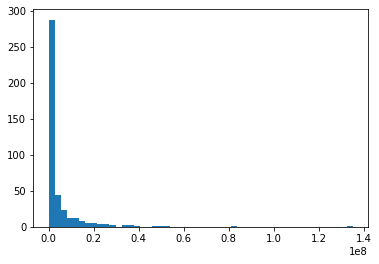

--------------------------------------------------
Model Dummy, OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2 :  -0.0003434549221106309 



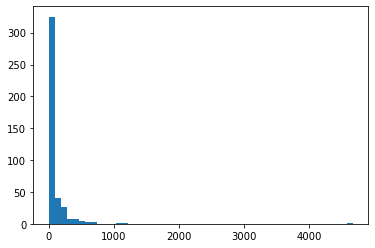

--------------------------------------------------


In [13]:
# dummyRegressor

for target in targets:

    dummy = make_pipeline(preprocessor,
                          DummyRegressor(strategy='median'))
    y_train = y_train_full[target]
    y_test = y_test_full[target]
    dummy.fit(X_train, np.ravel(np.log(y_train)))
    y_pred = np.exp(dummy.predict(X_test))

    # Model scoring
    print('Model Dummy, OneHotEncoder, RobustScaler')
    print('Prediction of: ', target, '\n')

    print('MAE :', mean_absolute_error(y_pred, y_test))
    print('RMSE :', mean_squared_error(y_pred, y_test))
    print('median abs err :', median_absolute_error(y_pred, y_test))
    print('RMSLE :', mean_squared_log_error(y_pred, y_test))
    print('R2 : ', dummy.score(X_test, np.log(y_test)), '\n')

    err_hist = np.abs(y_test - y_pred)
    plt.hist(err_hist, bins=50)
    plt.show()

    print('-'*50)

## Models evaluation

Scoring metrics defintion : 

    r2 : the coefficient of determination, usually denoted as R². It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.
    As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
    
    MAE : mean absolute error - a risk metric corresponding to the expected value of the absolute error loss
    
    median absolut error : is particularly interesting because it is robust to outliers. The loss is calculated by taking the median of all absolute differences between the target and the prediction.
    
    RMSE : root mean squared error - a risk metric corresponding to the expected value of the squared (quadratic) error or loss.
    
    RMSLE : root mean squared logarithmic error - function computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss.

R2 will be the metric score use to select best model, however a particular attention will be done around other metrics as well as the time need to fit.
    

In [14]:
# Definition of all algorithm to evaluate

algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'ElasticNet' : ElasticNet(),
    'SGDRegressor' : SGDRegressor(), 
    'LinearSVR' : LinearSVR(),
    'SVR' : SVR(), 
    'KNN' : KNeighborsRegressor(), 
    'DecisionTree' : DecisionTreeRegressor(),
    'RandomForest' : RandomForestRegressor(),
    'AdaBoost' : AdaBoostRegressor(),
    'Gboost' : GradientBoostingRegressor(),
    'XGboost' : XGBRegressor()
    }

Algorithm:  LinearRegression
Model LinearRegression OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.7845983994772828
R2_test :  0.7293602783374207
Execution time in seconds: 0.17958378791809082 



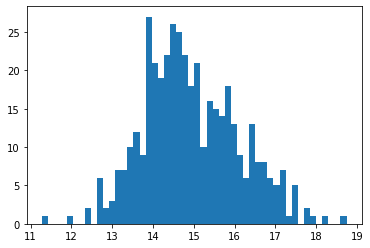

--------------------------------------------------
Model LinearRegression OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.8217104121278479
R2_test :  0.7739142860177631
Execution time in seconds: 0.21260619163513184 



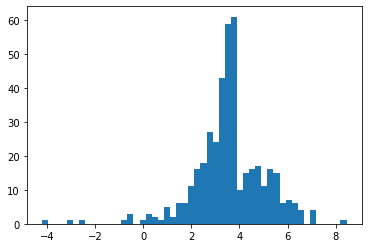

--------------------------------------------------
--------------------------------------------------
Algorithm:  Ridge
Model Ridge OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.19155810001686158
R2_test :  0.24687111097485215
Execution time in seconds: 0.0566258430480957 



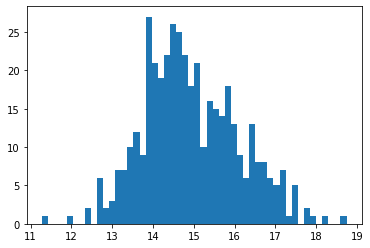

--------------------------------------------------
Model Ridge OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.0892316075192725
R2_test :  0.0995825497664965
Execution time in seconds: 0.05931901931762695 



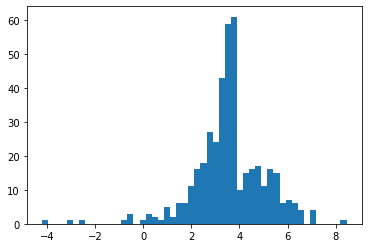

--------------------------------------------------
--------------------------------------------------
Algorithm:  Lasso
Model Lasso OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.2747384751635292
R2_test :  0.292394045546697
Execution time in seconds: 0.07405900955200195 



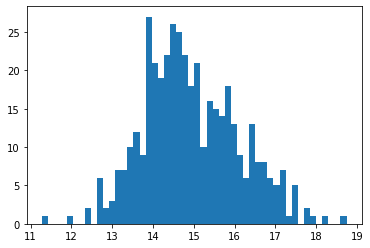

--------------------------------------------------
Model Lasso OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.1666316469168455
R2_test :  0.1449372340500087
Execution time in seconds: 0.14603304862976074 



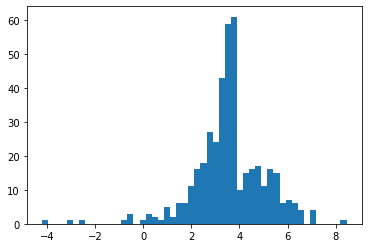

--------------------------------------------------
--------------------------------------------------
Algorithm:  ElasticNet
Model ElasticNet OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.39061707098745013
R2_test :  0.36393938430705464
Execution time in seconds: 0.0699009895324707 



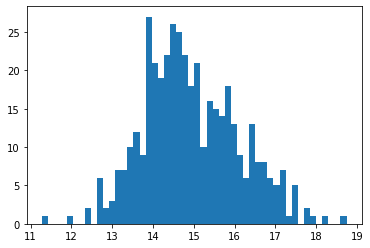

--------------------------------------------------
Model ElasticNet OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.25496672821188393
R2_test :  0.2029863334902542
Execution time in seconds: 0.1008918285369873 



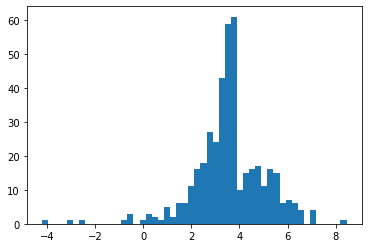

--------------------------------------------------
--------------------------------------------------
Algorithm:  SGDRegressor
Model SGDRegressor OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  -3.4019173577899116e+36
R2_test :  -4.2213150386304863e+36
Execution time in seconds: 0.07447695732116699 



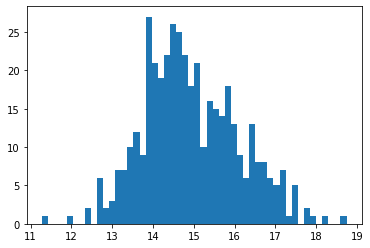

--------------------------------------------------
Model SGDRegressor OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  -6.759085203567222e+36
R2_test :  -8.744357278417347e+36
Execution time in seconds: 0.09084510803222656 



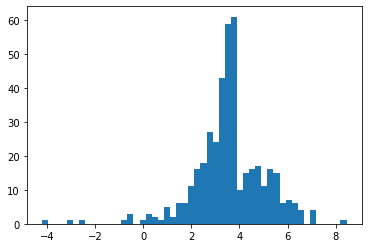

--------------------------------------------------
--------------------------------------------------
Algorithm:  LinearSVR
Model LinearSVR OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  -0.26091612237841666
R2_test :  -0.7175946049136968
Execution time in seconds: 0.18666601181030273 



/Users/franck/opt/anaconda3/envs/P4_devenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


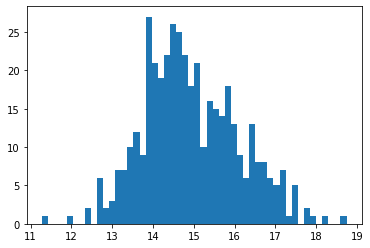

--------------------------------------------------


/Users/franck/opt/anaconda3/envs/P4_devenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model LinearSVR OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  -22.937797858667544
R2_test :  -59.51516307837749
Execution time in seconds: 0.2681918144226074 



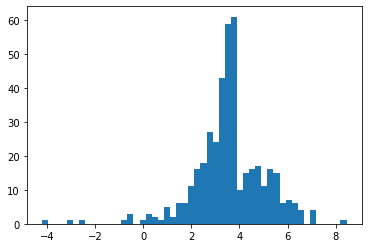

--------------------------------------------------
--------------------------------------------------
Algorithm:  SVR
Model SVR OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.27924873222614943
R2_test :  0.34228596268285594
Execution time in seconds: 0.6906228065490723 



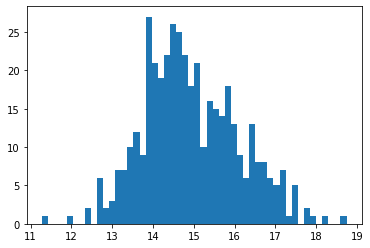

--------------------------------------------------
Model SVR OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.13359975468164254
R2_test :  0.16125297294306307
Execution time in seconds: 0.5665979385375977 



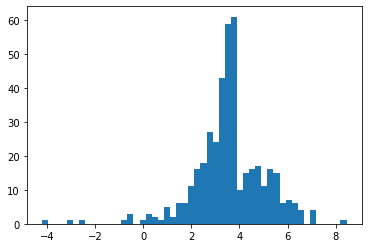

--------------------------------------------------
--------------------------------------------------
Algorithm:  KNN
Model KNN OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.8315438295596138
R2_test :  0.6925842172745287
Execution time in seconds: 0.2772500514984131 



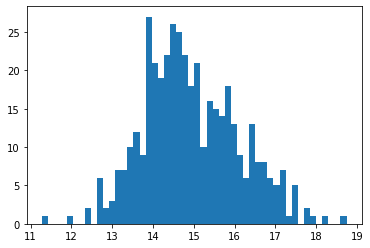

--------------------------------------------------
Model KNN OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.7692777542035816
R2_test :  0.6108197763104117
Execution time in seconds: 0.2834208011627197 



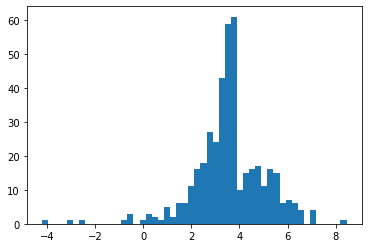

--------------------------------------------------
--------------------------------------------------
Algorithm:  DecisionTree
Model DecisionTree OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  1.0
R2_test :  0.8435041908265706
Execution time in seconds: 0.13097906112670898 



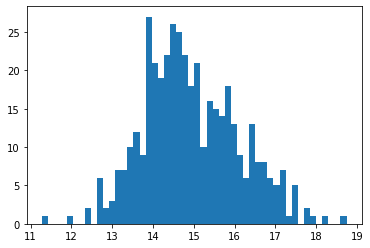

--------------------------------------------------
Model DecisionTree OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  1.0
R2_test :  0.8844191552639629
Execution time in seconds: 0.11841797828674316 



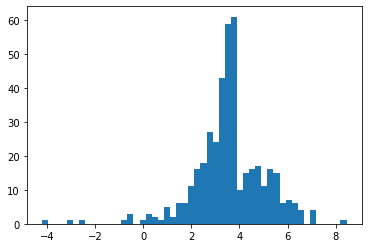

--------------------------------------------------
--------------------------------------------------
Algorithm:  RandomForest
Model RandomForest OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.9887063046253954
R2_test :  0.9226671296814012
Execution time in seconds: 7.024400949478149 



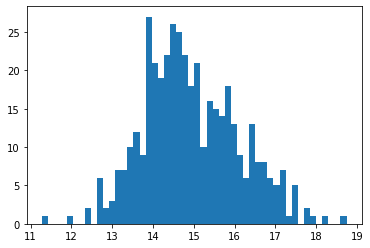

--------------------------------------------------
Model RandomForest OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.9893210388535141
R2_test :  0.9371081685247691
Execution time in seconds: 5.926464080810547 



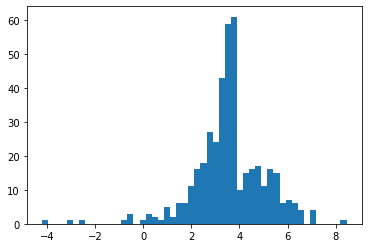

--------------------------------------------------
--------------------------------------------------
Algorithm:  AdaBoost
Model AdaBoost OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.8527133501651237
R2_test :  0.7966632028096776
Execution time in seconds: 1.7781329154968262 



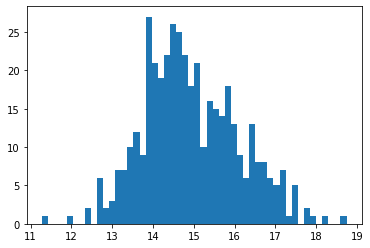

--------------------------------------------------
Model AdaBoost OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.8518520273340568
R2_test :  0.8174342581661325
Execution time in seconds: 1.1755409240722656 



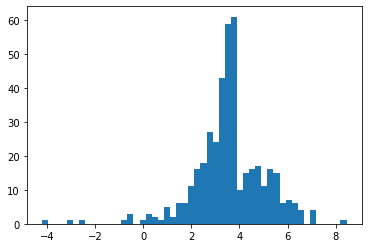

--------------------------------------------------
--------------------------------------------------
Algorithm:  Gboost
Model Gboost OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

MAE : 6361364.456132587
RMSE : 163022999801081.75
median abs err : 2649942.835000254
RMSLE : 122.8078747087803
R2_train :  0.9494216803891916
R2_test :  0.9052716338938412
Execution time in seconds: 0.7849888801574707 



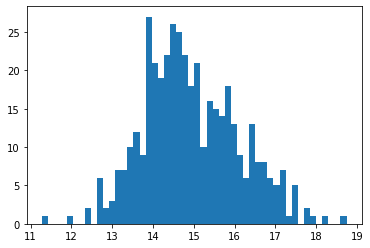

--------------------------------------------------
Model Gboost OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 97.96600000000001
RMSE : 83255.22085000173
median abs err : 35.785000000000004
RMSLE : 1.6273825900586727
R2_train :  0.9571458553224859
R2_test :  0.9209448644717558
Execution time in seconds: 0.6353967189788818 



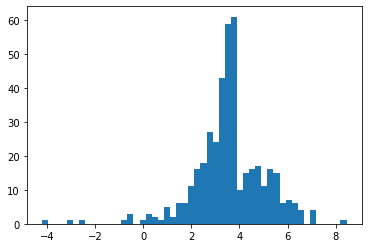

In [15]:
# Loop on all algorithm
results = []
for algo_name, algo in algos.items():
    print('Algorithm: ', algo_name)
    for target in targets:
        startTime = time.time()
        model = make_pipeline(preprocessor,
                              algo)
        y_train = y_train_full[target]
        y_test = y_test_full[target]
        model.fit(X_train, np.ravel(np.log(y_train)))
        y_pred = np.exp(dummy.predict(X_test))

        # Model scoring
        print('Model', algo_name, 'OneHotEncoder, RobustScaler')
        print('Prediction of: ', target, '\n')

        mae = mean_absolute_error(y_pred, y_test)
        print('MAE :', mae)
        rmse = mean_squared_error(y_pred, y_test)
        print('RMSE :', rmse)
        med_abs_err = median_absolute_error(y_pred, y_test)
        print('median abs err :', med_abs_err)
        rmsle = mean_squared_log_error(y_pred, y_test)
        print('RMSLE :', rmsle)
        R2_train = model.score(X_train, np.log(y_train))
        print('R2_train : ', R2_train)
        R2_test = model.score(X_test, np.log(y_test))
        print('R2_test : ', R2_test)
        executionTime = (time.time() - startTime)
        print('Execution time in seconds: ' + str(executionTime), '\n')

        err_hist = np.abs(y_test - y_pred)
        plt.hist(np.log(err_hist), bins=50)
        plt.show()
        results.append([algo_name,
                        target,
                        mae,
                        rmse,
                        med_abs_err,
                        rmsle,
                        R2_train,
                        R2_test,
                        executionTime])
        print('-'*50)
    print('-'*50)

In [ ]:
# Evaluation results display
df_results = pd.DataFrame(results, columns=['algorithm',
                                            'target',
                                            'MAE',
                                            'RMSE',
                                            'median abs err',
                                            'RMSLE',
                                            'predict score train',
                                            'predict score test',
                                            'Time to execute'])
display(df_results.sort_values(by=['target', 'predict score test'],
                               ascending=False))

,algorithm,target,MAE,RMSE,median abs err,RMSLE,predict score train,predict score test,Time to execute
25,XGboost,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,9.989603e-01,9.530999e-01,0.652628
19,RandomForest,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,9.893116e-01,9.367385e-01,5.411948
23,Gboost,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,9.571459e-01,9.208540e-01,1.140119
17,DecisionTree,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,1.000000e+00,8.790202e-01,0.156976
21,AdaBoost,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,8.455420e-01,8.154877e-01,0.417876
1,LinearRegression,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,8.217104e-01,7.739143e-01,0.128181
15,KNN,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,7.692778e-01,6.108198e-01,0.365204
7,ElasticNet,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,2.549667e-01,2.029863e-01,0.088523
13,SVR,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,1.335998e-01,1.612530e-01,0.697611
5,Lasso,TotalGHGEmissions,9.796600e+01,8.325522e+04,35.785,1.627383,1.666316e-01,1.449372e-01,0.130452


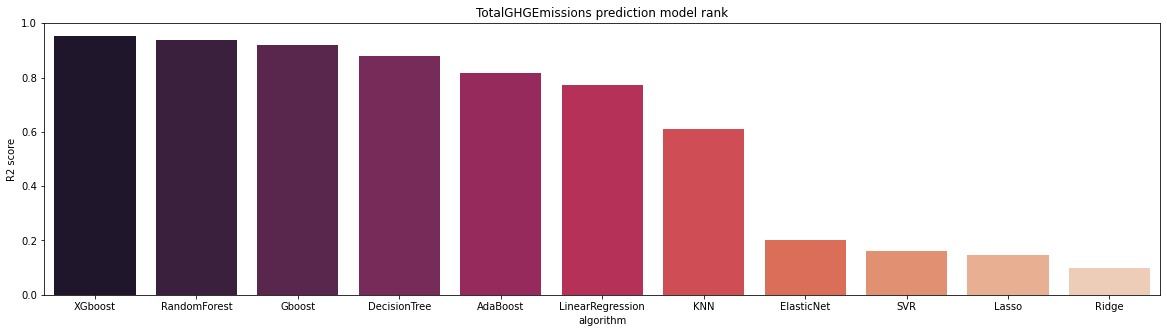

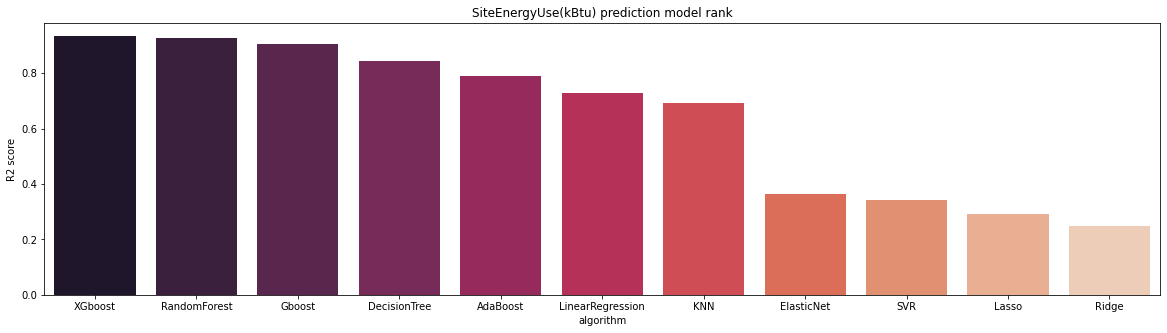

In [ ]:
# Evaluation visualisation

df_results.drop(df_results[df_results['predict score test'] < 0].index,
                inplace=True)

fig = plt.figure(figsize=(20, 5))
df_results_GHG = df_results.loc[df_results['target']
                                == 'TotalGHGEmissions', :].\
                                    sort_values(by=['predict score test'],
                                                ascending=False)
sns.barplot(data=df_results_GHG,
            x='algorithm',
            y='predict score test',
            palette='rocket')
plt.ylabel('R2 score')
plt.title('TotalGHGEmissions prediction model rank')
plt.show()

fig = plt.figure(figsize=(20, 5))
df_results_Energy = df_results.loc[df_results['target']
                                   == 'SiteEnergyUse(kBtu)', :].\
                                        sort_values(by=['predict score test'],
                                                    ascending=False)
sns.barplot(data=df_results_Energy,
            x='algorithm',
            y='predict score test',
            palette='rocket')
plt.ylabel('R2 score')
plt.title('SiteEnergyUse(kBtu) prediction model rank')
plt.show()

# Model tuning

## Random Forest

In [ ]:
# target init

target = 'TotalGHGEmissions'
# target = 'SiteEnergyUse(kBtu)'

y_train = y_train_full[target]
y_test = y_test_full[target]

### Basic model fitting

Model RandomForrest, OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 25.975205262004646
RMSE : 4777.497475329438
median abs err : 7.639618290243089
RMSLE : 0.10596289602229231
R2_train :  0.9890196175986291
R2_test :  0.9352399474157798
Execution time in seconds: 5.93601393699646 



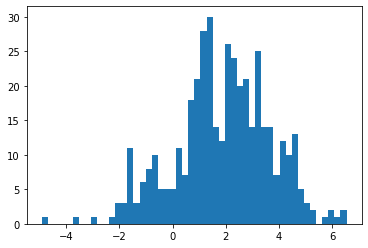

In [ ]:
# Basic Random forest model
startTime = time.time()

model = make_pipeline(preprocessor,
                      RandomForestRegressor())

model.fit(X_train, np.ravel(np.log(y_train)))

y_pred = np.exp(model.predict(X_test))

# Model scoring
print('Model RandomForrest, OneHotEncoder, RobustScaler')
print('Prediction of: ', target, '\n')

mae = mean_absolute_error(y_pred, y_test)
print('MAE :', mae)
rmse = mean_squared_error(y_pred, y_test)
print('RMSE :', rmse)
med_abs_err = median_absolute_error(y_pred, y_test)
print('median abs err :', med_abs_err)
rmsle = mean_squared_log_error(y_pred, y_test)
print('RMSLE :', rmsle)
R2_train = model.score(X_train, np.log(y_train))
print('R2_train : ', R2_train)
R2_test = model.score(X_test, np.log(y_test))
print('R2_test : ', R2_test)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime), '\n')

err_hist = np.abs(y_test - y_pred)
plt.hist(np.log(err_hist), bins=50)
plt.show()

### Features selection evaluation

In [ ]:
# Fit model using each importance as a threshold

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

regressor = model.named_steps['randomforestregressor']

thresholds = np.sort(np.unique(regressor.feature_importances_))

df_R2_test = list()
Nb_features = list()
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(regressor, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_scaled)
    # train model
    selection_model = RandomForestRegressor()
    selection_model.fit(select_X_train, np.log(y_train))
    # eval model
    select_X_test = selection.transform(X_test_scaled)
    df_R2_test.append(selection_model.score(select_X_test,
                                            np.log(y_test)))
    Nb_features.append(select_X_train.shape[1])
    print("Thresh=%f, n=%d, R2: %f%%" % (thresh,
                                         select_X_train.shape[1],
                                         selection_model.score(select_X_test,
                                                               np.log(y_test))))

In [ ]:
# Plot performance / features selection thresholds
fig, ax = plt.subplots(constrained_layout=True, figsize = (10, 5))
ax.plot(Nb_features, df_R2_test)

thresholds[df_R2_test.index(np.max(df_R2_test))]

In [ ]:
# Random Forest grid search CV Features Selection evaluation

startTime = time.time()

regressor = model.named_steps['randomforestregressor']

thresholds = np.sort(np.unique(regressor.feature_importances_))

model = make_pipeline(preprocessor, 
                      SelectFromModel(RandomForestRegressor()),
                      XGBRegressor(random_state=13))

param_grid =  {'selectfrommodel__threshold' : thresholds}

grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='r2', 
                    return_train_score=True)

grid.fit(X_train, np.ravel(np.log(y_train)))
y_pred = np.exp(grid.predict(X_test))

# Model scoring
print('Model RAndom Forest, OneHotEncoder, RobustScaler')
print('Prediction of: ', target, '\n')

print(grid.best_params_)

mae = mean_absolute_error(y_pred, y_test)
print('MAE :', mae)
rmse = mean_squared_error(y_pred, y_test)
print('RMSE :', rmse)
med_abs_err = median_absolute_error(y_pred, y_test)
print('median abs err :', med_abs_err)
rmsle = mean_squared_log_error(y_pred, y_test)
print('RMSLE :', rmsle)
R2_train = grid.score(X_train, np.log(y_train))
print('R2_train : ', R2_train)
R2_test = grid.score(X_test, np.log(y_test))
print('R2_test : ', R2_test)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime), '\n')

err_hist = np.abs(y_test - y_pred)
plt.hist(np.log(err_hist), bins=50)
plt.show()

To validate a model we need a scoring function, for example regression coefficient for regressor. The proper way of choosing multiple hyperparameters of an estimator are of course grid search or similar methods that select the hyperparameter with the maximum score on a validation set or multiple validation sets. Note that if we optimized the hyperparameters based on a validation score the validation score is biased and not a good estimate of the generalization any longer. To get a proper estimate of the generalization we have to compute the score on another test set.

However, it is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

If the training score and the validation score are both low, the estimator will be underfitting. If the training score is high and the validation score is low, the estimator is overfitting and otherwise it is working very well. A low training score and a high validation score is usually not possible

In [ ]:
plot_grid_search_validation_curve(grid, 'selectfrommodel__threshold', log=False)

### Hyperparamter tuning

Model RandomForrest, OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

{'randomforestregressor__max_depth': 100, 'randomforestregressor__max_features': None, 'randomforestregressor__n_estimators': 500}
MAE : 24.49336748294239
RMSE : 4067.883707501187
median abs err : 6.554464696533184
RMSLE : 0.10221550126136152
R2_train :  0.9899794842235853
R2_test :  0.9371611427612789
Execution time in seconds: 293.9345510005951 



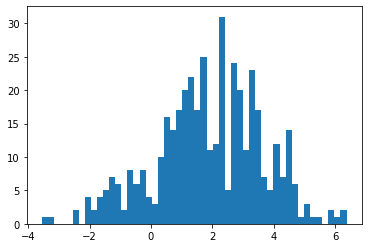

In [ ]:
# Random Forest grid search CV Hyperparamter Tuning

startTime = time.time()

model = make_pipeline(preprocessor,
                      RandomForestRegressor(random_state=13))

param_grid =  {'randomforestregressor__n_estimators': [100,500],
               'randomforestregressor__max_features': [None, "sqrt"],
               'randomforestregressor__max_depth' : [100, 200]}

grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='r2')

grid.fit(X_train, np.ravel(np.log(y_train)))
y_pred = np.exp(grid.predict(X_test))

# Model scoring
print('Model RandomForrest, OneHotEncoder, RobustScaler')
print('Prediction of: ', target, '\n')

print(grid.best_params_)

mae = mean_absolute_error(y_pred, y_test)
print('MAE :', mae)
rmse = mean_squared_error(y_pred, y_test)
print('RMSE :', rmse)
med_abs_err = median_absolute_error(y_pred, y_test)
print('median abs err :', med_abs_err)
rmsle = mean_squared_log_error(y_pred, y_test)
print('RMSLE :', rmsle)
R2_train = grid.score(X_train, np.log(y_train))
print('R2_train : ', R2_train)
R2_test = grid.score(X_test, np.log(y_test))
print('R2_test : ', R2_test)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime), '\n')

err_hist = np.abs(y_test - y_pred)
plt.hist(np.log(err_hist), bins=50)
plt.show()

### Features Importance

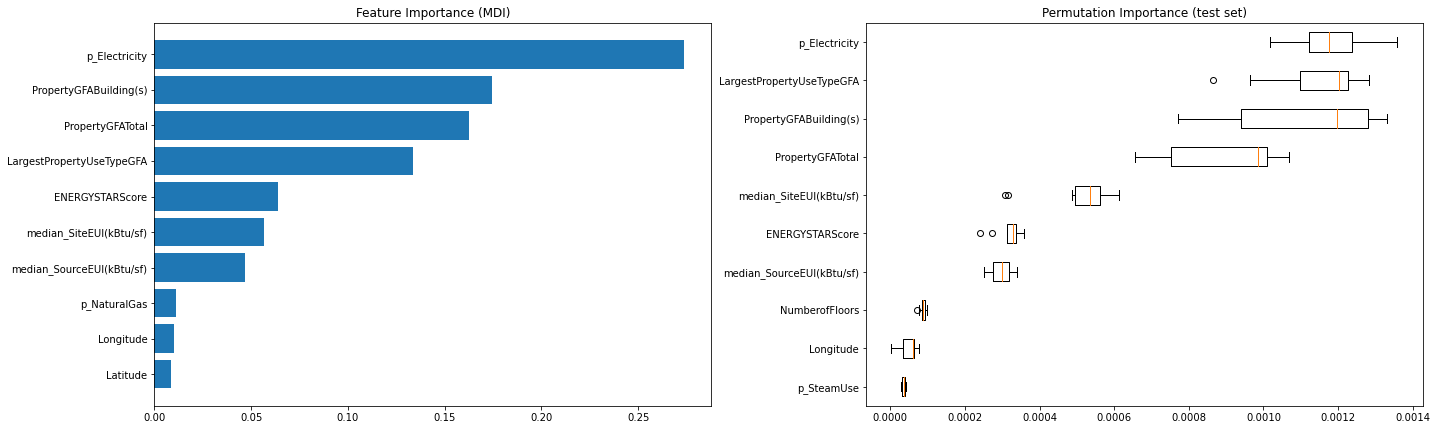

In [ ]:
# feature importance inspection
from sklearn.inspection import permutation_importance

# Recover features columns (especially after OneHotEncoder)
onehot_columns = list(preprocessor.named_transformers_['onehotencoder'].\
                          get_feature_names_out(input_features=categorical_features))
numeric_features_list = list(numeric_features)
features_list = np.concatenate((numeric_features_list, onehot_columns))

# Train model 
model = grid.best_estimator_
model = model.named_steps['randomforestregressor']


X_train_scaled = grid.best_estimator_.\
    named_steps['columntransformer'].fit_transform(X_train)
X_test_scaled = grid.best_estimator_.\
    named_steps['columntransformer'].transform(X_test)

# select features using threshold
#selector = grid.best_estimator_.named_steps['selectfrommodel']
#select_X_train = selector.transform(X_train_scaled)
#select_X_test = selector.transform(X_test_scaled)

# Recover important features from previous fit and then permute importance
n_feat = 10  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center')
plt.yticks(pos[-1*n_feat:], features_list[sorted_idx][-1*n_feat:])
plt.title('Feature Importance (MDI)')

result = permutation_importance(model,
                                X_test_scaled.toarray(),
                                y_test,
                                n_repeats=10,
                                random_state=42,
                                n_jobs=2)
sorted_idx = result.importances_mean.argsort()[-1*n_feat:]

plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T[-1*n_feat:],
            vert=False, labels=features_list[sorted_idx][-1*n_feat:])
plt.title("Permutation Importance (test set)")
fig.tight_layout(pad=0.8)
plt.show()

The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. In scikit-learn, the fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.

By averaging the estimates of predictive ability over several randomized trees one can reduce the variance of such an estimate and use it for feature selection. This is known as the mean decrease in impurity, or MDI. 



Warning

The impurity-based feature importances computed on tree-based models suffer from two flaws that can lead to misleading conclusions. First they are computed on statistics derived from the training dataset and therefore do not necessarily inform us on which features are most important to make good predictions on held-out dataset. Secondly, they favor high cardinality features, that is features with many unique values. Permutation feature importance is an alternative to impurity-based feature importance that does not suffer from these flaws.

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

### Learning Curve

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

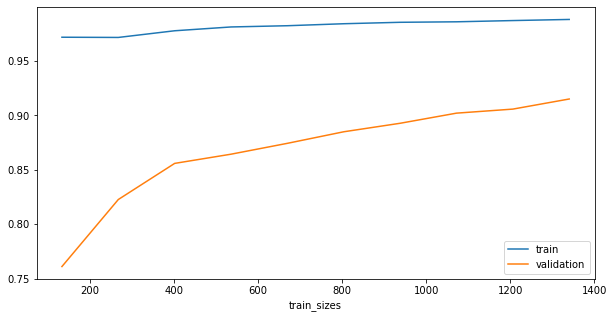

In [ ]:
# Learning Curve
forest = grid.best_estimator_

N, train_score, val_score = learning_curve(forest,
                                           X_train, np.log(y_train), 
                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                           cv=5,
                                           scoring='r2')

fig = plt.figure(figsize=(10, 5))
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axiS=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

## XGBoost

### Basic model fitting

In [ ]:
#target init

target = 'TotalGHGEmissions'
#target = 'SiteEnergyUse(kBtu)'

y_train = y_train_full[target]
y_test = y_test_full[target]

Model XgBoost, OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

MAE : 43.015124953469964
RMSE : 23163.602782961134
median abs err : 9.446241760253912
RMSLE : 0.1826190341485829
R2_train :  0.9893550109982107
R2_test :  0.9072724020659338
Execution time in seconds: 1.3351860046386719 



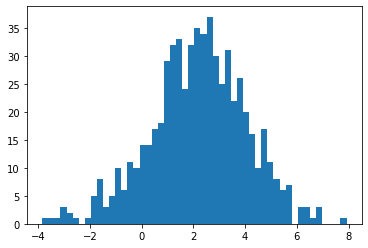

In [ ]:
# Basic XGBoost model
startTime = time.time()

model = make_pipeline(preprocessor,
                      XGBRegressor())

model.fit(X_train, np.ravel(np.log(y_train)))

y_pred = np.exp(model.predict(X_test))

# Model scoring
print('Model XgBoost, OneHotEncoder, RobustScaler')
print('Prediction of: ', target, '\n')

mae = mean_absolute_error(y_pred, y_test)
print('MAE :', mae)
rmse = mean_squared_error(y_pred, y_test)
print('RMSE :', rmse)
med_abs_err = median_absolute_error(y_pred, y_test)
print('median abs err :', med_abs_err)
rmsle = mean_squared_log_error(y_pred, y_test)
print('RMSLE :', rmsle)
R2_train = model.score(X_train, np.log(y_train))
print('R2_train : ', R2_train)
R2_test = model.score(X_test, np.log(y_test))
print('R2_test : ', R2_test)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime), '\n')

err_hist = np.abs(y_test - y_pred)
plt.hist(np.log(err_hist), bins=50)
plt.show()

### Features selection evaluation

Model XGBoost, OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

{'selectfrommodel__threshold': 0.0}
MAE : 24.33745137450241
RMSE : 5197.143045148418
median abs err : 6.513032836914064
RMSLE : 0.09072055789871131
R2_train :  0.9987752780134662
R2_test :  0.9444543326466431
Execution time in seconds: 1831.7178387641907 



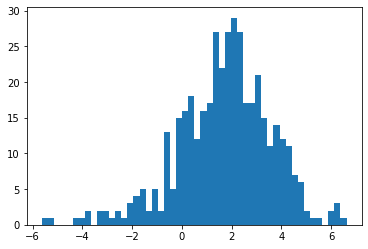

In [ ]:
# Random Forest grid search CV Features Selection evaluation

startTime = time.time()

regressor = model.named_steps['xgbregressor']

thresholds = np.sort(np.unique(regressor.feature_importances_))

model = make_pipeline(preprocessor, 
                      SelectFromModel(RandomForestRegressor()),
                      XGBRegressor(random_state=13))

param_grid =  {'selectfrommodel__threshold' : thresholds}

grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='r2', 
                    return_train_score= True)

grid.fit(X_train, np.ravel(np.log(y_train)))
y_pred = np.exp(grid.predict(X_test))

# Model scoring
print('Model XGBoost, OneHotEncoder, RobustScaler')
print('Prediction of: ', target, '\n')

print(grid.best_params_)

mae = mean_absolute_error(y_pred, y_test)
print('MAE :', mae)
rmse = mean_squared_error(y_pred, y_test)
print('RMSE :', rmse)
med_abs_err = median_absolute_error(y_pred, y_test)
print('median abs err :', med_abs_err)
rmsle = mean_squared_log_error(y_pred, y_test)
print('RMSLE :', rmsle)
R2_train = grid.score(X_train, np.log(y_train))
print('R2_train : ', R2_train)
R2_test = grid.score(X_test, np.log(y_test))
print('R2_test : ', R2_test)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime), '\n')

err_hist = np.abs(y_test - y_pred)
plt.hist(np.log(err_hist), bins=50)
plt.show()

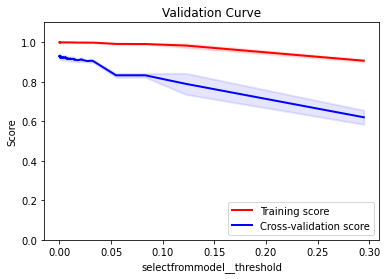

In [ ]:
plot_grid_search_validation_curve(grid, 'selectfrommodel__threshold', log=False)

In [ ]:
# Fit model using each importance as a threshold
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

model = model.named_steps['xgbregressor']

thresholds = np.sort(np.unique(model.feature_importances_))

df_R2_test = list()
Nb_features = list()
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_scaled)
    # train model
    selection_model = RandomForestRegressor()
    selection_model.fit(select_X_train, np.log(y_train))
    # eval model
    select_X_test = selection.transform(X_test_scaled)
    df_R2_test.append(selection_model.score(select_X_test, np.log(y_test)))
    Nb_features.append(select_X_train.shape[1])
    print("Thresh=%f, n=%d, R2: %f%%" % (thresh, select_X_train.shape[1], selection_model.score(select_X_test, np.log(y_test))))
    
#Plot performance / features selection thresholds
fig, ax = plt.subplots(constrained_layout=True, figsize = (10, 5))
ax.plot(thresholds, df_R2_test)

thresholds[Nb_features.index(np.max(df_R2_test))]

### Hyperparamters tuning

Model XGboost, OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

{'xgbregressor__learning_rate': 0.03, 'xgbregressor__n_estimators': 600, 'xgbregressor__subsample': 0.5}
MAE : 38.76185893802551
RMSE : 8878.087084936711
median abs err : 9.924962005615235
RMSLE : 0.17526249062296712
R2_train :  0.981152835083463
R2_test :  0.9109406154457891
Execution time in seconds: 236.64426612854004 



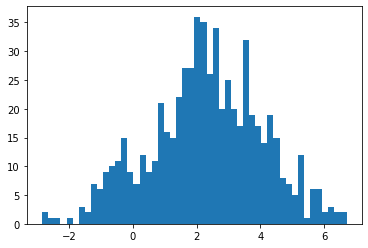

In [ ]:
# XGboost grid search CV 

startTime = time.time()

model = make_pipeline(preprocessor,
                      XGBRegressor())


param_grid =  {'xgbregressor__n_estimators': [100,300,600],
               'xgbregressor__learning_rate': [0.01,0.03,0.6],
               'xgbregressor__subsample'    : [1, 0.5, 0.1]}

grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='r2',
                    return_train_score=True)

grid.fit(X_train, np.ravel(np.log(y_train)))


y_pred = np.exp(grid.predict(X_test))

# Model scoring
print('Model XGboost, OneHotEncoder, RobustScaler')
print('Prediction of: ', target, '\n')

print(grid.best_params_)

mae = mean_absolute_error(y_pred, y_test)
print('MAE :', mae)
rmse = mean_squared_error(y_pred, y_test)
print('RMSE :', rmse)
med_abs_err = median_absolute_error(y_pred, y_test)
print('median abs err :', med_abs_err)
rmsle = mean_squared_log_error(y_pred, y_test)
print('RMSLE :', rmsle)
R2_train = grid.score(X_train, np.log(y_train))
print('R2_train : ', R2_train)
R2_test = grid.score(X_test, np.log(y_test))
print('R2_test : ', R2_test)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime), '\n')

err_hist = np.abs(y_test - y_pred)
plt.hist(np.log(err_hist), bins=50)
plt.show()

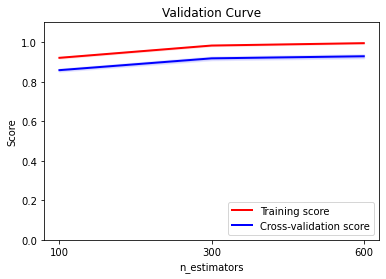

In [ ]:
plot_grid_search_validation_curve(grid, 'n_estimators', log=False)

### Features importance

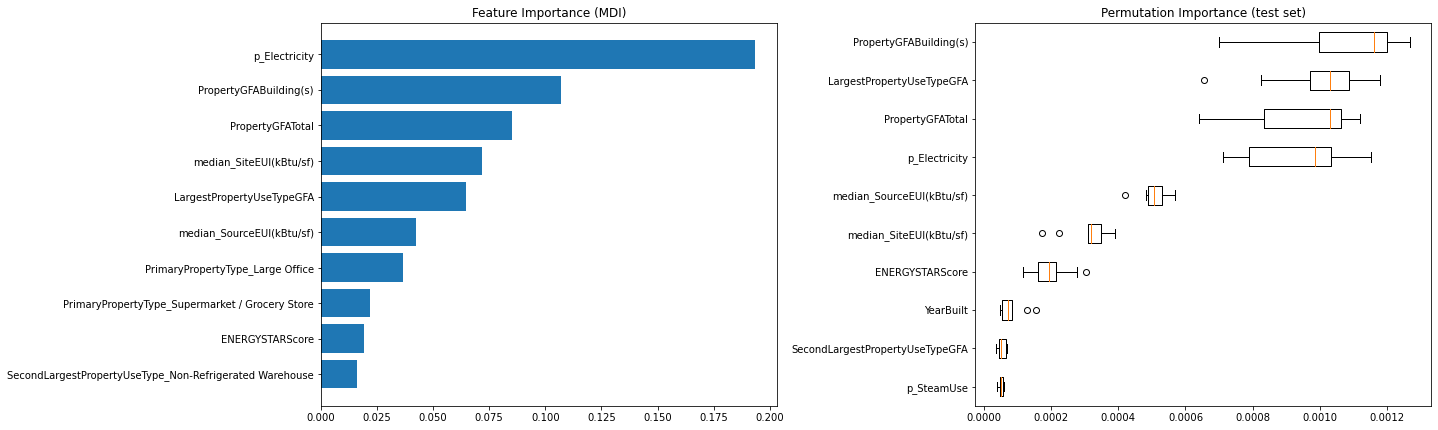

In [ ]:
# feature importance inspection
from sklearn.inspection import permutation_importance

# Recover features columns (especially after OneHotEncoder)
onehot_columns = list(preprocessor.named_transformers_['onehotencoder'].\
                          get_feature_names_out(input_features=categorical_features))
numeric_features_list = list(numeric_features)
features_list = np.concatenate((numeric_features_list, onehot_columns))

# Train model with best estimator from previous GridSearchCV
model = grid.best_estimator_
model = model.named_steps['xgbregressor']

# Recover important features from previous fit and then permute importance
n_feat = 10  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center')
plt.yticks(pos[-1*n_feat:], features_list[sorted_idx][-1*n_feat:])
plt.title('Feature Importance (MDI)')

result = permutation_importance(model,
                                X_test_scaled.toarray(),
                                y_test,
                                n_repeats=10,
                                random_state=42,
                                n_jobs=2)
sorted_idx = result.importances_mean.argsort()[-1*n_feat:]

plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T[-1*n_feat:],
            vert=False,
            labels=features_list[sorted_idx][-1*n_feat:])
plt.title("Permutation Importance (test set)")
fig.tight_layout(pad=0.8)
plt.show()

### Learning Curve

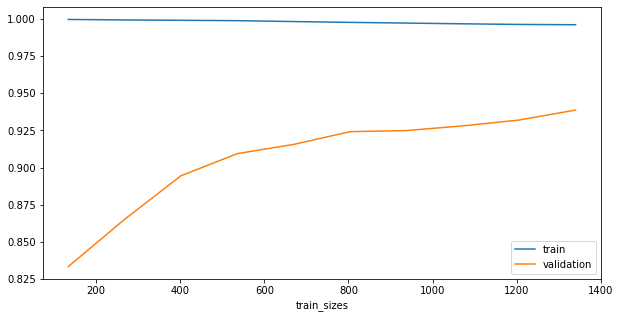

In [ ]:
# Learning Curve AVEC
xgBoost = grid.best_estimator_

N, train_score, val_score = learning_curve(xgBoost,
                                           X_train,
                                           np.log(y_train),
                                           train_sizes=np.linspace(0.1,1.0, 10),
                                           cv=5,
                                           scoring='r2')

fig = plt.figure(figsize=(10, 5))
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

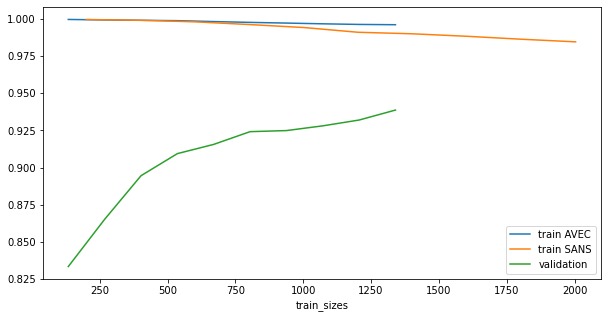

In [ ]:
# Learning Curve SANS
xgBoost = grid.best_estimator_

N_sans, train_score_sans, val_score_sans = learning_curve(xgBoost,
                                                          X_train,
                                                          np.log(y_train),
                                                          train_sizes = np.linspace(0.1, 1.0, 10),
                                                          cv=5,
                                                          scoring='r2')

fig = plt.figure(figsize=(10, 5))
plt.plot(N, train_score.mean(axis=1), label='train AVEC')
plt.plot(N_sans, train_score_sans.mean(axis=1), label='train SANS')
plt.plot(N, val_score.mean(axis=1), label='validation AVEC')
plt.plot(N_sans, val_score_sans.mean(axis=1), label='validation SANS')
plt.xlabel('train_sizes')
plt.legend()

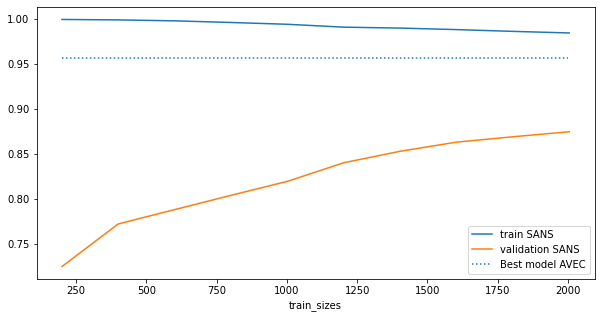

In [ ]:
fig = plt.figure(figsize=(10, 5))

plt.plot(N_sans, train_score_sans.mean(axis=1), label='train SANS')
plt.plot(N_sans, val_score_sans.mean(axis=1), label='validation SANS')
plt.hlines(y=0.957, xmin=200, xmax=2000, linestyles='dotted', label='Best model AVEC')
plt.xlabel('train_sizes')
plt.legend()

## Conclusion

Based on the R2, the optimized XGboost model, offers the best prediction of CO2 emission and Energy Use with a R2 of 95.7% and 94.5% respectively. Also time to fit is quiet similar so no need to select over this criteria. 
ENERGYSTARscore seems to be a importante features to predict CO2 Emissions as the study of MDI and permutation importance rank this features in the top 10 of importante features. More over if we try to predict GHGEmssions without this feature, even with bigger sample size the R2 score is still lower.

# Test Simple linear regression

Model XGboost, OneHotEncoder, RobustScaler
Prediction of:  SiteEnergyUse(kBtu) 

{}
MAE : 68.90914741481899
RMSE : 31272.98822294565
median abs err : 26.64692538579665
RMSLE : 0.7375627126624991
R2_train :  0.621698296974639
R2_test :  0.5389806649061897
Execution time in seconds: 0.411790132522583 



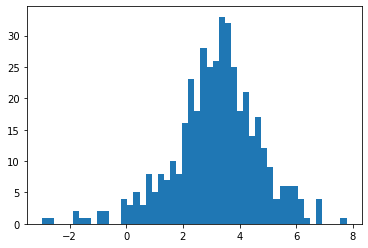

Model XGboost, OneHotEncoder, RobustScaler
Prediction of:  TotalGHGEmissions 

{}
MAE : 68.90914741481899
RMSE : 31272.98822294565
median abs err : 26.64692538579665
RMSLE : 0.7375627126624991
R2_train :  0.621698296974639
R2_test :  0.5389806649061897
Execution time in seconds: 0.36110901832580566 



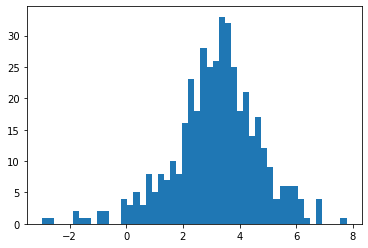

In [ ]:
for target in targets:
    startTime = time.time()
    
    model = make_pipeline(preprocessor,
                          LinearRegression())

    param_grid =  {}

    grid = GridSearchCV(model,
                        param_grid,
                        cv=5,
                        scoring='r2')

    grid.fit(X_train, np.ravel(np.log(y_train)))

    y_pred = np.exp(grid.predict(X_test))

    # Model scoring
    print('Model XGboost, OneHotEncoder, RobustScaler')
    print('Prediction of: ', target, '\n')

    print(grid.best_params_)

    mae = mean_absolute_error(y_pred, y_test)
    print('MAE :', mae)
    rmse = mean_squared_error(y_pred, y_test)
    print('RMSE :', rmse)
    med_abs_err = median_absolute_error(y_pred, y_test)
    print('median abs err :', med_abs_err)
    rmsle = mean_squared_log_error(y_pred, y_test)
    print('RMSLE :', rmsle)
    R2_train = grid.score(X_train, np.log(y_train))
    print('R2_train : ', R2_train)
    R2_test = grid.score(X_test, np.log(y_test))
    print('R2_test : ', R2_test)
    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime), '\n')

    err_hist = np.abs(y_test - y_pred)
    plt.hist(np.log(err_hist), bins=50)
    plt.show()

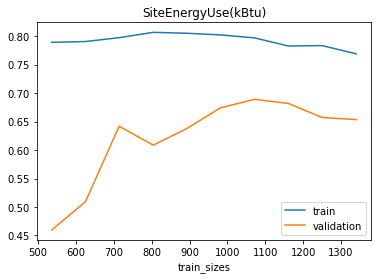

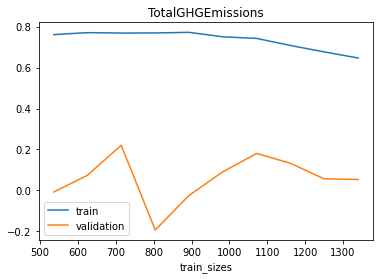

In [ ]:
# Learning Curve

for target in targets:
    
    model = make_pipeline(preprocessor,
                   LinearRegression())
    
    N, train_score, val_score = learning_curve(model,
                                               X_train,
                                               y_train_full[target], 
                                               train_sizes=np.linspace(0.4, 1.0, 10),
                                               cv=5,
                                               scoring='r2')

    plt.plot(N, train_score.mean(axis=1), label='train')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.title(target)
    plt.xlabel('train_sizes')
    plt.legend()
    plt.show()

### Ridge regression

In [ ]:
#Ridge regulation visualisation

y_model = y['TotalGHGEmissions']

n_alphas = 60
alphas = np.logspace(-5, 5, 11)

processed_X = preprocessor.fit_transform(X)

X_train2, X_test2, y_train2, y_test2 = train_test_split(processed_X,
                                                        np.ravel(np.log(y_model)),
                                                        test_size=0.2,
                                                        random_state=13)

In [ ]:
ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train2, y_train2)
    coefs.append(ridge.coef_)
    errors.append(np.mean((ridge.predict(X_test2) - y_test2) ** 2))

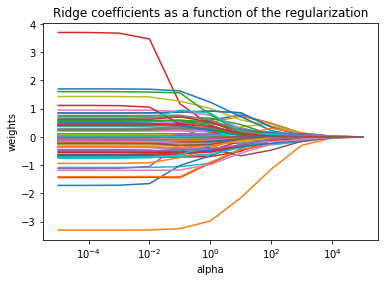

In [ ]:
# Ridge coefficients as a function of the regularization
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

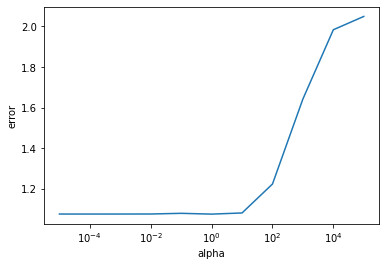

In [ ]:
# Best alpha
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [ ]:
# ridge regression GridSearch 'TotalGHGEmissions'

ridge = make_pipeline(preprocessor, 
                      Ridge(random_state=0))
params = { 
    'ridge__alpha' : np.logspace(-5, 5, 50)
}

grid = GridSearchCV(ridge,
                    param_grid=params,
                    cv=5,
                    scoring='r2',
                    return_train_score=True)

startTime = time.time()
grid.fit(X_train, np.log(y_train_full['TotalGHGEmissions']))
executionTime = (time.time() - startTime)

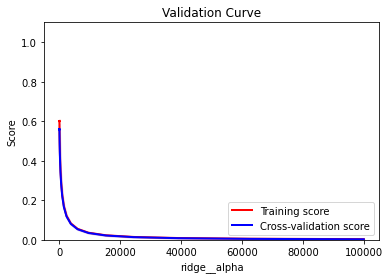

In [ ]:
plot_grid_search_validation_curve(grid, 'ridge__alpha', log=False)


Model Ridge, OneHotEncoder, RobustScaler
Prediction of: TotalGHGEmissions 

{'ridge__alpha': 0.30888435964774846}
MAE : 66.1866425877039
RMSE : 26810.518099702087
median abs err : 22.421382228929886
RMSLE : 0.8334503060744322
R2_train :  0.5959600676934877
R2_test :  0.4782280161472362
Execution time in seconds: 9.799011945724487 



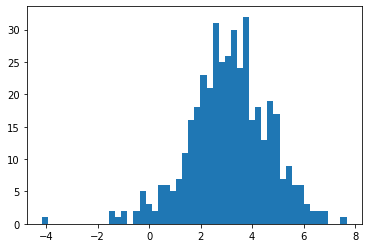

In [ ]:
ridge = grid.best_estimator_
y_pred = np.exp(ridge.predict(X_test))


# Model scoring
print('Model Ridge, OneHotEncoder, RobustScaler')
print('Prediction of: TotalGHGEmissions \n')

print(grid.best_params_)

mae = mean_absolute_error(y_pred, y_test)
print('MAE :', mae)
rmse = mean_squared_error(y_pred, y_test)
print('RMSE :', rmse)
med_abs_err = median_absolute_error(y_pred, y_test)
print('median abs err :', med_abs_err)
rmsle = mean_squared_log_error(y_pred, y_test)
print('RMSLE :', rmsle)
R2_train = ridge.score(X_train, np.log(y_train))
print('R2_train : ', R2_train)
R2_test = ridge.score(X_test, np.log(y_test))
print('R2_test : ', R2_test)

print('Execution time in seconds: ' + str(executionTime), '\n')

err_hist = np.abs(y_test - y_pred)
plt.hist(np.log(err_hist), bins=50)
plt.show()

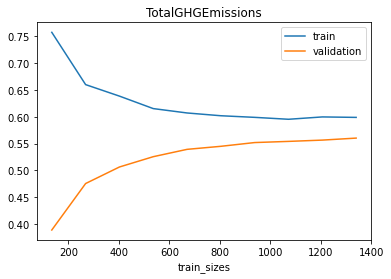

In [ ]:
# Learning Curve
N, train_score, val_score = learning_curve(ridge,
                                           X_train,
                                           np.log(y_train_full['TotalGHGEmissions']), 
                                           train_sizes=np.linspace(0.1,1.0, 10),
                                           cv=5,
                                           scoring='r2')

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.title(target)
plt.xlabel('train_sizes')
plt.legend()
plt.show()

### Lasso regression

In [ ]:
#Lasso regulation visualisation

y_model = y['TotalGHGEmissions']

n_alphas = 60
alphas = np.logspace(-5, 5, 11)

processed_X = preprocessor.fit_transform(X)

X_train2, X_test2, y_train2, y_test2 = train_test_split(processed_X,
                                                        np.ravel(np.log(y_model)),
                                                        test_size=0.2,
                                                        random_state=13)

lasso = Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train2, y_train2)
    coefs.append(lasso.coef_)
    errors.append(np.mean((lasso.predict(X_test2) - y_test2) ** 2))

/Users/franck/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.4593916261138, tolerance: 0.3578009113581225
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/franck/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0623103624295709, tolerance: 0.3578009113581225
  model = cd_fast.sparse_enet_coordinate_descent(


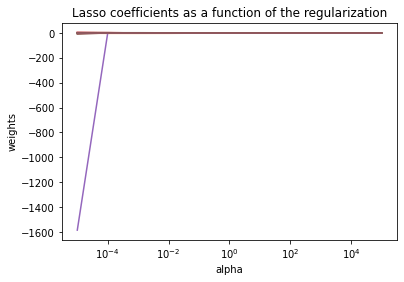

In [ ]:
# Lasso coefficients as a function of the regularization
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

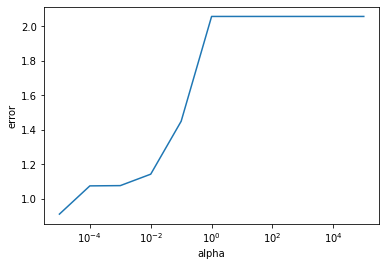

In [ ]:
# Best alpha
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [ ]:
# lasso regression GridSearch 'TotalGHGEmissions'

lasso = make_pipeline(preprocessor, 
                      Lasso(random_state=0))
params = { 
    'lasso__alpha' : np.logspace(-5, 5, 50)
}

grid = GridSearchCV(lasso,
                    param_grid=params,
                    cv=5,
                    scoring='r2',
                    return_train_score=True)

startTime = time.time()
grid.fit(X_train, np.log(y_train_full['TotalGHGEmissions']))
executionTime = (time.time() - startTime)

/Users/franck/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.7236179223458, tolerance: 0.2899564806035315
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/franck/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.84310353510898, tolerance: 0.29873821191772687
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/franck/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.97260838945942, tolerance: 0.3015419516868522
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/franck/opt/anaconda3/lib/python3.8/s

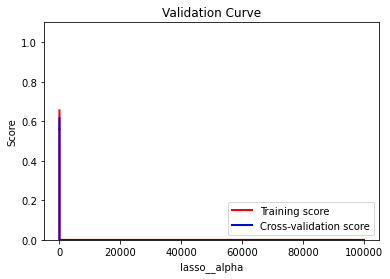

In [ ]:
plot_grid_search_validation_curve(grid, 'lasso__alpha', log=False)

Model Lasso, OneHotEncoder, RobustScaler
Prediction of: TotalGHGEmissions 

{'lasso__alpha': 1e-05}
MAE : 62.141779057271265
RMSE : 24453.944431275973
median abs err : 23.580636591451892
RMSLE : 0.6860109716763072
R2_train :  0.652229561081842
R2_test :  0.5712656180899969
Execution time in seconds: 22.271809577941895 



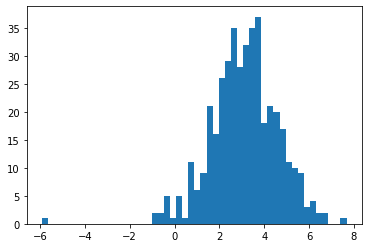

In [ ]:
lasso = grid.best_estimator_
y_pred = np.exp(lasso.predict(X_test))


# Model scoring
print('Model Lasso, OneHotEncoder, RobustScaler')
print('Prediction of: TotalGHGEmissions \n')

print(grid.best_params_)

mae = mean_absolute_error(y_pred, y_test)
print('MAE :', mae)
rmse = mean_squared_error(y_pred, y_test)
print('RMSE :', rmse)
med_abs_err = median_absolute_error(y_pred, y_test)
print('median abs err :', med_abs_err)
rmsle = mean_squared_log_error(y_pred, y_test)
print('RMSLE :', rmsle)
R2_train = lasso.score(X_train, np.log(y_train))
print('R2_train : ', R2_train)
R2_test = lasso.score(X_test, np.log(y_test))
print('R2_test : ', R2_test)

print('Execution time in seconds: ' + str(executionTime), '\n')

err_hist = np.abs(y_test - y_pred)
plt.hist(np.log(err_hist), bins=50)
plt.show()